In [31]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, month, desc, col, hour, dayofweek, month, sin, cos, unix_timestamp, lit, round, when, count, expr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher, VectorAssembler, StandardScaler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
import streamlit as st
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import math


In [2]:
def create_spark_session():
    spark = SparkSession.builder \
        .appName("NYC Taxi Analytics") \
        .config("spark.sql.shuffle.partitions", "8") \
        .getOrCreate()
    return spark

spark = create_spark_session()

In [3]:
# Data Ingestion
data_path = "nyc_yellow_taxi_trip_records_from_Jan_to_Aug_2023.csv"
df_raw = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .csv(data_path)

In [4]:
df_raw.printSchema()
print(f"Rows: {df_raw.count()}  Columns: {len(df_raw.columns)}")
df_raw.select("passenger_count", "trip_distance", "fare_amount") \
      .describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee19: double (nullable = true)
 |-- airport_fee20: double (nullable = true)

Rows: 19493059  Columns: 21
+-------+------

In [5]:
# Show first 5 columns of the dataset
first10_cols = df_raw.columns[:10]
df_raw.select(*first10_cols).show(10)

First 10 columns: ['_c0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID']
+---+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+
|_c0|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|
+---+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+
|  0|       2| 2023-06-30 23:59:59|  2023-07-01 00:47:49|            2.0|        17.62|       2.0|                 N|         132|         230|
|  1|       2| 2023-06-30 23:59:57|  2023-07-01 00:17:36|            1.0|         3.32|       1.0|                 N|         255|         198|
|  2|       1| 2023-06-30 23:59:55|  2023-07-01 00:14:20|            1.0|          2.8|  

In [6]:
# Show the next 11 columns of the dataset
next11_cols = df_raw.columns[10:21]
df_raw.select(*next11_cols).show(10)

Next 11 columns: ['payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee19', 'airport_fee20']
+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------+-------------+
|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee19|airport_fee20|
+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-------------+-------------+
|           1|       70.0|  0.0|    0.5|       0.0|        6.55|                  1.0|        82.3|                 2.5|         1.75|         NULL|
|           1|       18.4|  1.0|    0.5|       2.5|         0.0|                  1.0|        23.4|                 0.0|          0.0|         NULL|
|           1|       14.9|  3.5|    0.5|      3.95|      

In [5]:
#Check for null/missing values
null_counts = df_raw.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_raw.columns
])

# 2) Pivot that single row into a vertical two-column table
vertical_null_counts = null_counts.selectExpr(
    "stack({n}, {exprs}) as (column_name, null_count)".format(
        n=len(df_raw.columns),
        exprs=", ".join([f"'{c}', `{c}`" for c in df_raw.columns])
    )
)

vertical_null_counts.show(truncate=False)


+---------------------+----------+
|column_name          |null_count|
+---------------------+----------+
|_c0                  |0         |
|VendorID             |0         |
|tpep_pickup_datetime |0         |
|tpep_dropoff_datetime|0         |
|passenger_count      |528530    |
|trip_distance        |0         |
|RatecodeID           |528530    |
|store_and_fwd_flag   |528530    |
|PULocationID         |0         |
|DOLocationID         |0         |
|payment_type         |0         |
|fare_amount          |0         |
|extra                |0         |
|mta_tax              |0         |
|tip_amount           |0         |
|tolls_amount         |0         |
|improvement_surcharge|0         |
|total_amount         |0         |
|congestion_surcharge |528530    |
|Airport_fee19        |3523475   |
+---------------------+----------+
only showing top 20 rows



In [5]:
# Calculate the null values into percentage

total_rows = df_raw.count()

null_counts = df_raw.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_raw.columns
])

vertical_null_counts = null_counts.selectExpr(
    "stack({n}, {exprs}) as (column_name, null_count)".format(
        n=len(df_raw.columns),
        exprs=", ".join([f"'{c}', `{c}`" for c in df_raw.columns])
    )
)

vertical_null_counts = vertical_null_counts.withColumn(
    "percent_null",
    round(col("null_count") / lit(total_rows) * 100, 2)
)

vertical_null_counts.show(21, False)


+---------------------+----------+------------+
|column_name          |null_count|percent_null|
+---------------------+----------+------------+
|_c0                  |0         |0.0         |
|VendorID             |0         |0.0         |
|tpep_pickup_datetime |0         |0.0         |
|tpep_dropoff_datetime|0         |0.0         |
|passenger_count      |528530    |2.71        |
|trip_distance        |0         |0.0         |
|RatecodeID           |528530    |2.71        |
|store_and_fwd_flag   |528530    |2.71        |
|PULocationID         |0         |0.0         |
|DOLocationID         |0         |0.0         |
|payment_type         |0         |0.0         |
|fare_amount          |0         |0.0         |
|extra                |0         |0.0         |
|mta_tax              |0         |0.0         |
|tip_amount           |0         |0.0         |
|tolls_amount         |0         |0.0         |
|improvement_surcharge|0         |0.0         |
|total_amount         |0         |0.0   

In [6]:
#Drop columns with null values > 80%

total_rows = df_raw.count()

null_counts = df_raw.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_raw.columns
]).collect()[0].asDict()

# Identify columns with >80% nulls
cols_to_drop = [c for c, n in null_counts.items() if n / total_rows > 0.8]
print("Dropping columns (>=80% null):", cols_to_drop)

df_raw_drop = df_raw.drop(*cols_to_drop)
#df_raw_clean.printSchema()

Dropping columns (>=80% null): ['airport_fee20']


In [7]:
# (1) drop irrelevant columns such as _c0 and mta_tax
# (2) drop redundant columns fare_amount, extra, tip_amount, tolls_amount, improvement_surcharge, congestion_surcharge and Airport_fee19, sum of this equal
#  to total_amount 
df_raw_clean = df_raw_drop.drop("_c0", "mta_tax", "fare_amount", "extra", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "Airport_fee19" )

In [8]:
#fillna for categorical features with missing values 
from pyspark.sql.types import StringType

cat_cols = [f.name for f in df_raw_clean.schema.fields if isinstance(f.dataType, StringType)]

df_raw_filled = df_raw_clean.fillna({c: "missing" for c in cat_cols})

# Verify no nulls remain in categorical columns
from pyspark.sql.functions import col, count, when
df_raw_filled.select([
    count(when(col(c).isNull(), c)).alias(c) 
    for c in cat_cols
]).show()

+------------------+
|store_and_fwd_flag|
+------------------+
|                 0|
+------------------+



In [9]:
df_raw_filled.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)



In [10]:
# Impute median and mean to numerical column with missing values
# Identify all numeric columns
numeric_cols = [f.name for f in df_raw_filled.schema.fields 
                if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType))]

# Median imputation for passenger_count and RatecodeID
median_cols = ["passenger_count", "RatecodeID"]
median_imputer = Imputer(
    inputCols=median_cols,
    outputCols=median_cols,
    strategy="median"
)
df_imputed = median_imputer.fit(df_raw_filled).transform(df_raw_filled)

# Mean imputation for the remaining numeric columns
mean_cols = [c for c in numeric_cols if c not in median_cols]
mean_imputer = Imputer(
    inputCols=mean_cols,
    outputCols=mean_cols,
    strategy="mean"
)
df_final = mean_imputer.fit(df_imputed).transform(df_imputed)

# Verify that nulls have been filled in the imputed columns
imputed_cols = median_cols + mean_cols  # median_cols and mean_cols defined during imputation

from pyspark.sql.functions import col, count, when
df_final.select([
    count(when(col(c).isNull(), c)).alias(c) 
    for c in imputed_cols
]).show()


+---------------+----------+--------+-------------+------------+------------+------------+------------+
|passenger_count|RatecodeID|VendorID|trip_distance|PULocationID|DOLocationID|payment_type|total_amount|
+---------------+----------+--------+-------------+------------+------------+------------+------------+
|              0|         0|       0|            0|           0|           0|           0|           0|
+---------------+----------+--------+-------------+------------+------------+------------+------------+



In [11]:
# Drop rows where total_amount or trip_distance is negative -> Invalid values
df_final = df_final.filter(
    (col("total_amount") >= 0) & 
    (col("trip_distance") >= 0)
)

EDA

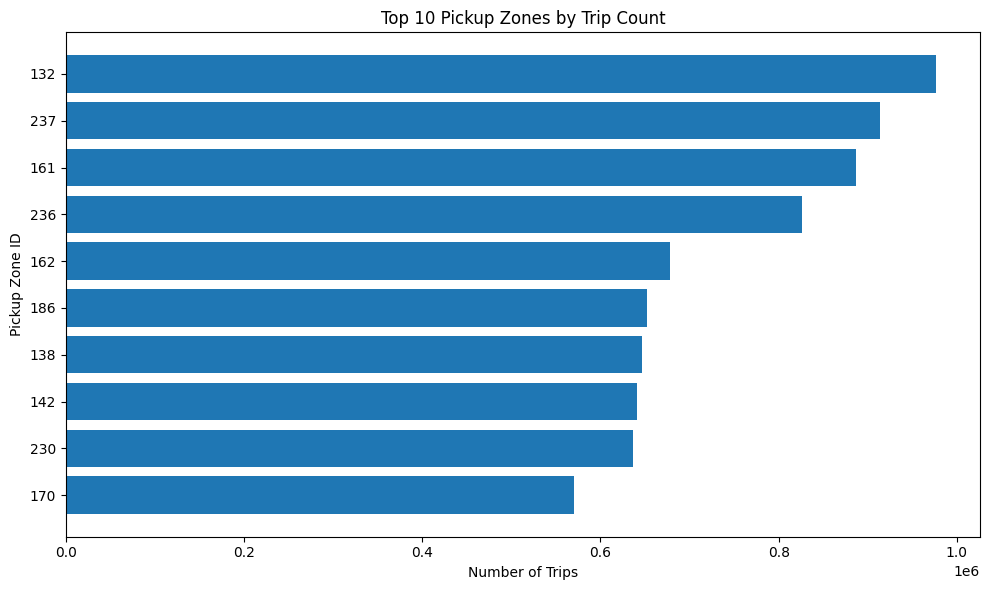

In [13]:
# Get top 10 pickup zones by count
top10 = (
    df_final
    .groupBy("PULocationID")
    .count()
    .orderBy(desc("count"))
    .limit(10)
    .toPandas()
)

# Sort ascending so the largest bar is at the top of a horizontal bar plot
top10_sorted = top10.sort_values("count", ascending=True)

# Plot horizontal bar chart arranged from highest to lowest
plt.figure(figsize=(10, 6))
plt.barh(top10_sorted["PULocationID"].astype(str), top10_sorted["count"])
plt.xlabel("Number of Trips")
plt.ylabel("Pickup Zone ID")
plt.title("Top 10 Pickup Zones by Trip Count")
plt.tight_layout()
plt.show()

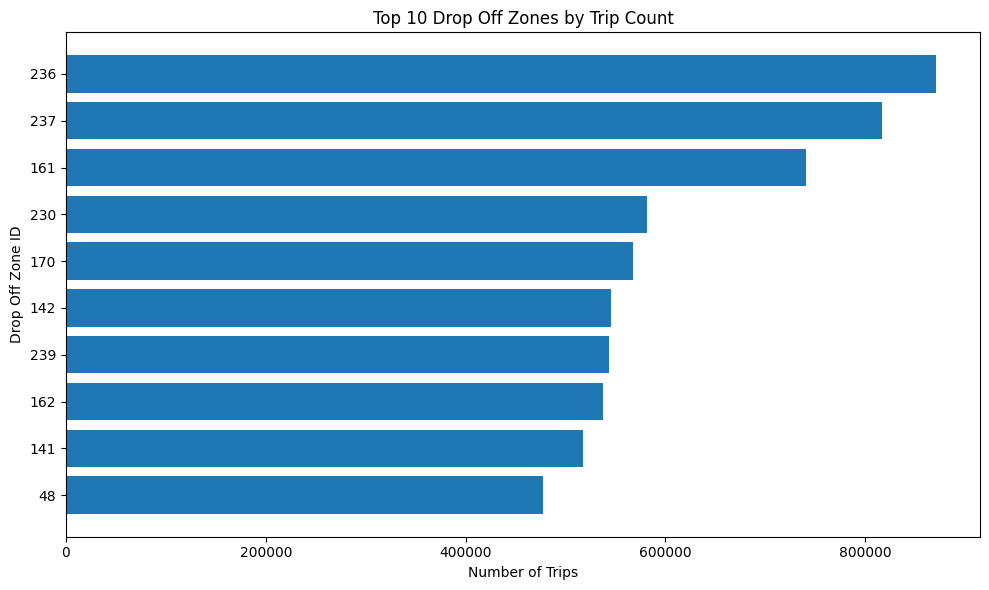

In [14]:
# Get top 10 pickup zones by count
top10 = (
    df_final
    .groupBy("DOLocationID")
    .count()
    .orderBy(desc("count"))
    .limit(10)
    .toPandas()
)

# Sort ascending so the largest bar is at the top of a horizontal bar plot
top10_sorted = top10.sort_values("count", ascending=True)

# Plot horizontal bar chart arranged from highest to lowest
plt.figure(figsize=(10, 6))
plt.barh(top10_sorted["DOLocationID"].astype(str), top10_sorted["count"])
plt.xlabel("Number of Trips")
plt.ylabel("Drop Off Zone ID")
plt.title("Top 10 Drop Off Zones by Trip Count")
plt.tight_layout()
plt.show()

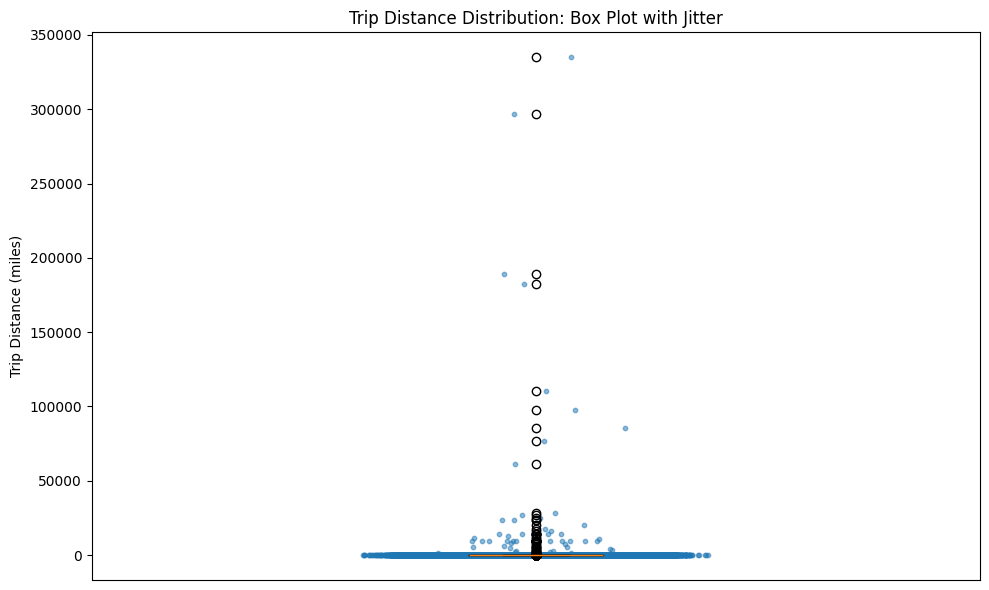

In [15]:
# Box Plot of Trip Distance Distribution
# Sample a subset and convert to Pandas
pdf = df_final.select("trip_distance") \
              .sample(False, 0.1, seed=42) \
              .toPandas()
values = pdf["trip_distance"].dropna().values

# Create box plot with jittered points
fig, ax = plt.subplots(figsize=(10, 6))

# Vertical boxplot at x=1
ax.boxplot(values, positions=[1], vert=True)

# Jitter: random x-values around 1
x_jitter = np.random.normal(loc=1, scale=0.04, size=len(values))
ax.scatter(x_jitter, values, alpha=0.5, s=10)

# Remove x-axis tick
ax.set_xticks([])

# Labels and title
ax.set_ylabel("Trip Distance (miles)")
ax.set_title("Trip Distance Distribution: Box Plot with Jitter")

plt.tight_layout()
plt.show()


Trip distance IQR: [-2.40, 6.88]
Rows before: 19320641, after outlier removal: 16769117


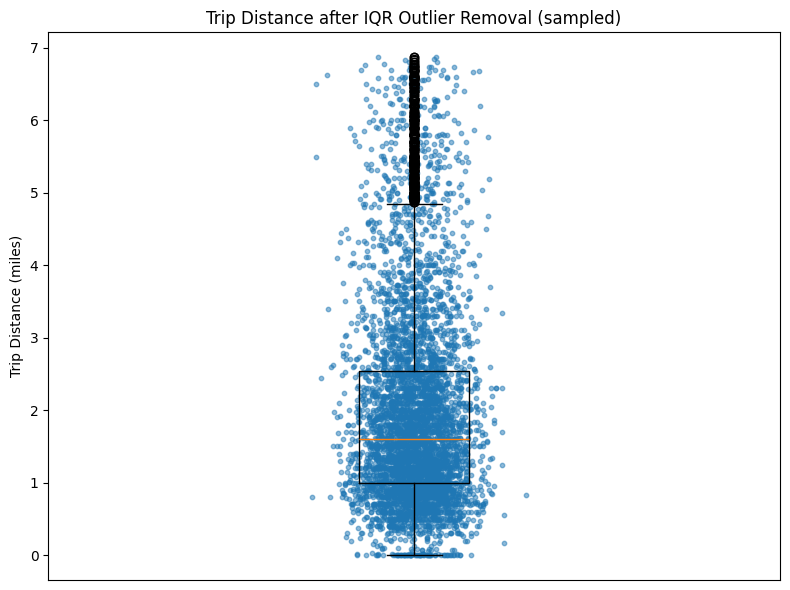

In [16]:
# Box Plot of Trip Distance Distribution without Outliers removed via IQR

# Compute Q1 and Q3 on the full DataFrame
quantiles = df_final.approxQuantile("trip_distance", [0.25, 0.75], 0.01)
q1, q3 = quantiles
iqr = q3 - q1

# Define lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
df_no_outliers = df_final.filter(
    (col("trip_distance") >= lower_bound) &
    (col("trip_distance") <= upper_bound)
)

print(f"Trip distance IQR: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Rows before: {df_final.count()}, after outlier removal: {df_no_outliers.count()}")

# Convert to Pandas and re-plot without outliers
pdf_clean = (df_no_outliers
                .sample(False, 0.005, seed=42)
                .limit(5000)
                .toPandas())

values = pdf_clean["trip_distance"].dropna().values

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(values, positions=[1], vert=True)

# jitter around x=1
x_jitter = np.random.normal(loc=1, scale=0.04, size=len(values))
ax.scatter(x_jitter, values, alpha=0.5, s=10)

ax.set_xticks([])
ax.set_ylabel("Trip Distance (miles)")
ax.set_title("Trip Distance after IQR Outlier Removal (sampled)")
plt.tight_layout()
plt.show()


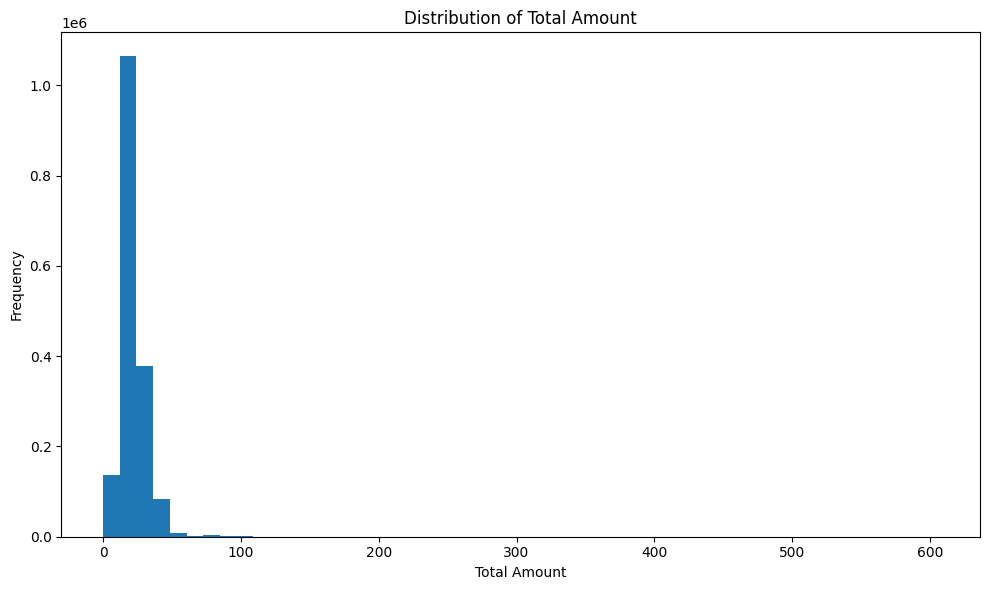

In [17]:
# Histogram of Total Amount Distribution
# Sample ~10% of total_amount values to avoid pulling the entire dataset
pdf_clean2 = df_no_outliers.select("total_amount") \
              .sample(False, 0.1, seed=42) \
              .toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pdf_clean2["total_amount"].dropna(), bins=50)
plt.xlabel("Total Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Total Amount")
plt.tight_layout()
plt.show()


Observed long tail of total amount distribution

+----+------------------+
|hour| avg(total_amount)|
+----+------------------+
|   0| 22.22833966135579|
|   1|  21.8777770373552|
|   2|21.730412464552018|
|   3|21.765710561771485|
|   4|22.403831458943188|
|   5|20.627091358897392|
|   6|18.693935709009025|
|   7|19.201446989164264|
|   8|19.963971353144274|
|   9|20.194314307573507|
|  10| 20.24289050555876|
|  11| 20.56288898945603|
|  12|20.619756768068108|
|  13|21.080202267757322|
|  14| 20.86704802576535|
|  15|21.046039192005857|
|  16|22.969321143125722|
|  17| 23.02163280592401|
|  18|22.541404329677796|
|  19| 22.05401780206179|
+----+------------------+
only showing top 20 rows



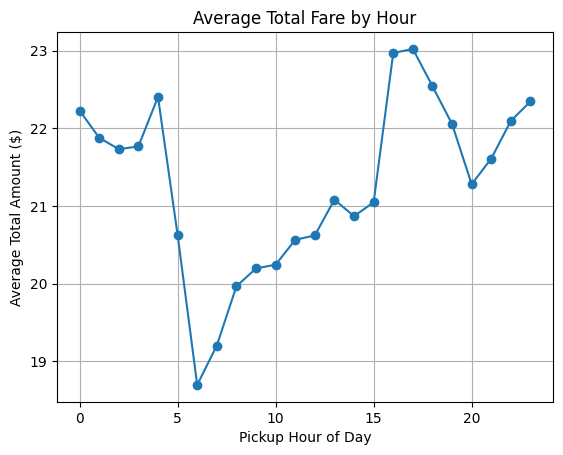

In [18]:
# Temporal Patterns
# To show the peak hour of pickup in a day
# Goals: capture rush hours, weekday/weekend, monthly trends

df_final_wtime = (
    df_no_outliers
      .withColumn("pickup_ts", to_timestamp(col("tpep_pickup_datetime")))
      .withColumn("hour",    hour("pickup_ts"))
      .withColumn("dow",     dayofweek("pickup_ts"))
      .withColumn("month",   month("pickup_ts"))
)

# Performing the aggregations
df_final_wtime.groupBy("hour").avg("total_amount").orderBy("hour").show() 

pdf = df_final_wtime.groupBy("hour") \
             .avg("total_amount") \
             .orderBy("hour") \
             .toPandas()

import matplotlib.pyplot as plt
plt.plot(pdf["hour"], pdf["avg(total_amount)"], marker="o")
plt.xlabel("Pickup Hour of Day")
plt.ylabel("Average Total Amount ($)")
plt.title("Average Total Fare by Hour")
plt.grid(True)
plt.show()

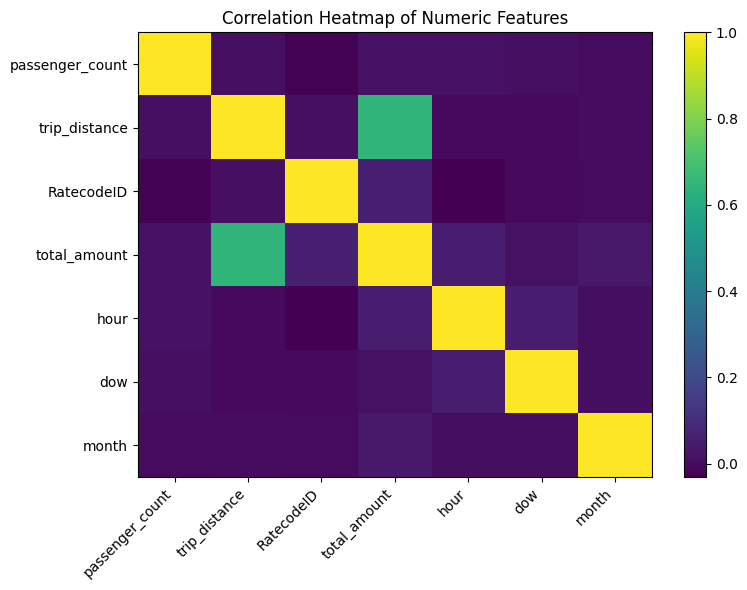

In [20]:
# Correlation heatmap
# Numeric columns
numeric_cols = [
    "passenger_count",
    "trip_distance",
    "RatecodeID",
    "total_amount",
    "hour",
    "dow",
    "month"
]

pdf = (
    df_final_wtime
    .select(numeric_cols)
    .sample(False, 0.05, seed=42)      # e.g. 5% sample
    .toPandas()
)

# Compute correlation matrix
corr = pdf.corr()

# Plot heatmap with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


In [21]:
df_final_wtime.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_ts: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- month: integer (nullable = true)



In [30]:
# Saving the file into csv
output_dir = "df_final_wtime"

df_final_wtime.coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(output_dir)

print(f"df_final_wtime has been written to directory:\n   {output_dir}")
print("Inside this folder you will find a file named something like `part-00000-*.csv` which is your actual CSV.")


df_final_wtime has been written to directory:
   df_final_wtime
Inside this folder you will find a file named something like `part-00000-*.csv` which is your actual CSV.


Feature Engineering

In [37]:
#Derive duration & cyclical time features
df_postFE = (
    df_final_wtime
    # duration in seconds
    .withColumn(
        "trip_secs",
        unix_timestamp("tpep_dropoff_datetime") -
        unix_timestamp("tpep_pickup_datetime")
    )
    # extract raw time parts
    .withColumn("hour", hour("tpep_pickup_datetime"))
    .withColumn("dow", dayofweek("tpep_pickup_datetime") - 1)  # 0=Sunday…6=Saturday
    .withColumn("month", month("tpep_pickup_datetime"))
    # cyclical transforms
    .withColumn("hour_sin", sin(2 * math.pi * col("hour") / 24))
    .withColumn("hour_cos", cos(2 * math.pi * col("hour") / 24))
    .withColumn("dow_sin", sin(2 * math.pi * col("dow") / 7))
    .withColumn("dow_cos", cos(2 * math.pi * col("dow") / 7))
    .withColumn("month_sin", sin(2 * math.pi * col("month") / 12))
    .withColumn("month_cos", cos(2 * math.pi * col("month") / 12))
)

# 4) Index & one-hot encode low-cardinality categoricals
cat_cols = ["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type"]
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]
ohe = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_vec" for c in cat_cols],
    dropLast=True
)

# 5) Hash high-cardinality location IDs into a fixed vector
hasher = FeatureHasher(
    inputCols=["PULocationID", "DOLocationID"],
    outputCol="locs_hashed",
    numFeatures=128
)

# 6) Assemble everything into a single “raw_features” vector
numeric_cols = [
    "passenger_count",
    "trip_distance",
    "trip_secs",
    "hour_sin","hour_cos",
    "dow_sin","dow_cos",
    "month_sin","month_cos"
]
assembler = VectorAssembler(
    inputCols=(
        numeric_cols
        + [f"{c}_vec" for c in cat_cols]
        + ["locs_hashed"]
    ),
    outputCol="raw_features"
)

# 7) Standard-scale (helpful for linear/regularized models)
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,
    withStd=True
)

In [38]:
df_postFE.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_ts: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- trip_secs: long (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- dow_sin: double (nullable = true)
 |-- dow_cos: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)



In [39]:
# Saving the output data after feature engineering completed
output_dir = "df_postFE"

df_postFE.coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(output_dir)

print(f"df_final_wtime has been written to directory:\n   {output_dir}")
print("Inside this folder you will find a file named something like `part-00000-*.csv` which is your actual CSV.")

df_final_wtime has been written to directory:
   df_postFE
Inside this folder you will find a file named something like `part-00000-*.csv` which is your actual CSV.
